# Download requirements

In [ ]:
install.packages('fGarch')

In [1]:
library(fGarch)
library(forecast)

Warning message:
"package 'fGarch' was built under R version 3.6.3"Loading required package: timeDate
Loading required package: timeSeries
Warning message:
"package 'timeSeries' was built under R version 3.6.3"Loading required package: fBasics
Warning message:
"package 'fBasics' was built under R version 3.6.3"Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho NoDur portfolio

#### Lấy dữ liệu của NoDur porfolio

In [4]:
series <- ts(data = data$NoDur, start = c(1963,7), end = c(2022,4), frequency = 12) 

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-21.020  -1.242   1.080   1.049   3.720  18.850 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale()

In [8]:
series_train %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.23598 -0.01410  0.01030  0.01086  0.04105  0.17269 

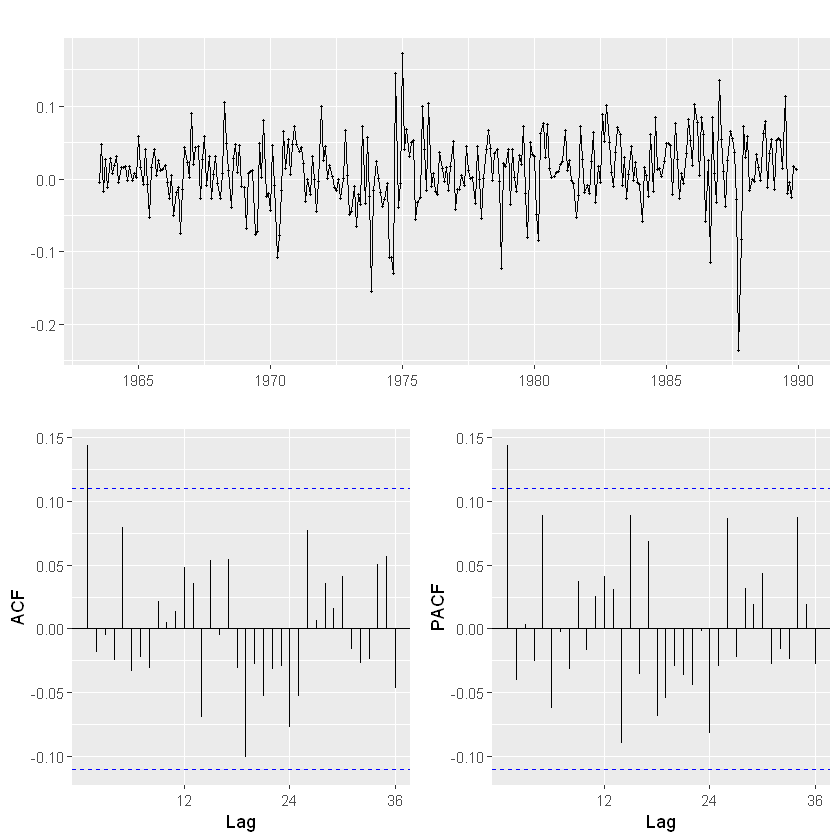

In [9]:
series_train %>% ggtsdisplay()

In [10]:
auto.arima(series_train, stepwise = FALSE, approximation = FALSE)

Series: series_train 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
          ar1     ma1    mean
      -0.8161  0.9237  0.0108
s.e.   0.0929  0.0647  0.0027

sigma^2 estimated as 0.002144:  log likelihood=527.28
AIC=-1046.55   AICc=-1046.43   BIC=-1031.51

#### Chọn tham số cho mô hình ARMA-GARCH

In [11]:
fit <- garchFit(formula = ~arma(1, 2) + garch(1, 1), data = series_train)


Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(1, 2)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 1)
 ARMA Order:                1 2
 Max ARMA Order:            2
 GARCH Order:               1 1
 Max GARCH Order:           1
 Maximum Order:             2
 Conditional Dist:          norm
 h.start:                   3
 llh.start:                 1
 Length of Series:          318
 Recursion Init:            mci
 Series Scale:              0.0469344

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.31283335   2.312833  0.2321258     TRUE
    ar1    -0.99999999   1.000000 -0.9389265     TRUE
    ma1    -0.99999999   1.000000  1.1158508     TRUE
    ma2    -0.99999999   1.000000  0.1184549     TRUE
    omega   0.00000100 100.000000  0.1000000  

In [12]:
fit@fit$ics

AIC       BIC       SIC      HQIC 
-3.340333 -3.257520 -3.341274 -3.307257

In [13]:
fitted <- ts(data = fit@fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
true <- ts(data = fit@data, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv

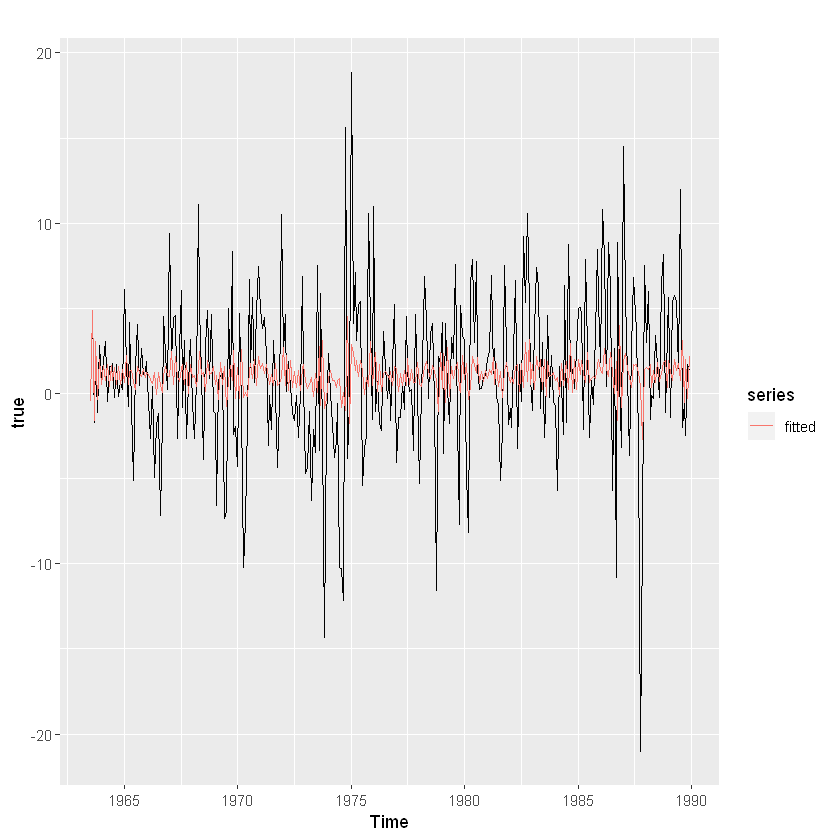

In [14]:
autoplot(true)+autolayer(fitted)

In [15]:
(true - fitted)^2 %>% mean %>% sqrt

[1] 4.607523

In [19]:
pred <- NULL
for (i in 0:399)
{
    train <- series %>% subset(end=length(series)-400+i) %>% log_scale()
    fit <- garchFit(formula = ~arma(1, 2) + garch(1, 1), data = train)
    pred_val <- predict(fit, n.ahead = 1)$meanForecast %>% log_inv()
    pred <- c(pred, pred_val)
}
pred <- ts(pred, start=c(1990,1), frequency = 12)
true <- series %>% window(start=c(1990,1))
rmse <- sqrt(mean((true-pred)^2))


Series Initialization:
 ARMA Model:                arma
 Formula Mean:              ~ arma(1, 2)
 GARCH Model:               garch
 Formula Variance:          ~ garch(1, 1)
 ARMA Order:                1 2
 Max ARMA Order:            2
 GARCH Order:               1 1
 Max GARCH Order:           1
 Maximum Order:             2
 Conditional Dist:          norm
 h.start:                   3
 llh.start:                 1
 Length of Series:          306
 Recursion Init:            mci
 Series Scale:              0.04711549

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.17981031   2.17981  0.21807785     TRUE
    ar1    -0.99999999   1.00000 -0.85526126     TRUE
    ma1    -0.99999999   1.00000  1.02668095     TRUE
    ma2    -0.99999999   1.00000  0.08633686     TRUE
    omega   0.00000100 100.00000  0.10000000 

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.34102504   2.341025  0.2337816     TRUE
    ar1    -0.99999999   1.000000 -0.9400740     TRUE
    ma1    -0.99999999   1.000000  1.1228189     TRUE
    ma2    -0.99999999   1.000000  0.1228357     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25458189   2.254582  0.22496229     TRUE
    ar1    -0.99999999   1.000000  0.55010795     TRUE
    ma1    -0.99999999   1.000000 -0.43107666     TRUE
    ma2    -0.99999999   1.000000 -0.09062633     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.28780464   2.287805  0.22775028     TRUE
    ar1    -0.99999999   1.000000  0.51519152     TRUE
    ma1    -0.99999999   1.000000 -0.39535663     TRUE
    ma2    -0.99999999   1.000000 -0.08919883     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.29946888   2.299469  0.23086260     TRUE
    ar1    -0.99999999   1.000000  0.48565741     TRUE
    ma1    -0.99999999   1.000000 -0.36559581     TRUE
    ma2    -0.99999999   1.000000 -0.08413238     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.29029334   2.290293  0.22810083     TRUE
    ar1    -0.99999999   1.000000  0.50313190     TRUE
    ma1    -0.99999999   1.000000 -0.38408959     TRUE
    ma2    -0.99999999   1.000000 -0.08526563     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.26111110   2.261111  0.22553114     TRUE
    ar1    -0.99999999   1.000000  0.54583902     TRUE
    ma1    -0.99999999   1.000000 -0.42899174     TRUE
    ma2    -0.99999999   1.000000 -0.08777289     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.26250663   2.262507  0.22526894     TRUE
    ar1    -0.99999999   1.000000  0.51357101     TRUE
    ma1    -0.99999999   1.000000 -0.39677698     TRUE
    ma2    -0.99999999   1.000000 -0.08339805     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25133861   2.251339  0.22542515     TRUE
    ar1    -0.99999999   1.000000  0.56280730     TRUE
    ma1    -0.99999999   1.000000 -0.44598546     TRUE
    ma2    -0.99999999   1.000000 -0.08782599     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.29488549   2.294885  0.22980948     TRUE
    ar1    -0.99999999   1.000000  0.57765182     TRUE
    ma1    -0.99999999   1.000000 -0.46023916     TRUE
    ma2    -0.99999999   1.000000 -0.09148961     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.29208998   2.29209  0.22844259     TRUE
    ar1    -0.99999999   1.00000  0.55785902     TRUE
    ma1    -0.99999999   1.00000 -0.44109783     TRUE
    ma2    -0.99999999   1.00000 -0.08941927     TRUE
    omega   0.00000100 100.00000  0.10000000     TRUE
    alpha1  0.00000001   1.00000  0.10000000     TRUE
    gamma1 -0.99999999   1.00000  0.10000000    FALSE
    beta1   0.00000001   1.00000  0.80000000     TRUE
    delta   0.00000000   2.00000  2.00000000    FALSE
    skew    0.10000000  10.00000  1.00000000    FALSE
    shape   1.00000000  10.00000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.28584942   2.285849  0.22877452     TRUE
    ar1    -0.99999999   1.000000  0.58200636     TRUE
    ma1    -0.99999999   1.000000 -0.46450229     TRUE
    ma2    -0.99999999   1.000000 -0.09216915     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27851869   2.278519  0.22635268     TRUE
    ar1    -0.99999999   1.000000  0.55457761     TRUE
    ma1    -0.99999999   1.000000 -0.43656037     TRUE
    ma2    -0.99999999   1.000000 -0.08862059     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27576488   2.275765  0.22708392     TRUE
    ar1    -0.99999999   1.000000  0.59966078     TRUE
    ma1    -0.99999999   1.000000 -0.48287822     TRUE
    ma2    -0.99999999   1.000000 -0.09303852     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.28373924   2.283739  0.22817379     TRUE
    ar1    -0.99999999   1.000000  0.55886513     TRUE
    ma1    -0.99999999   1.000000 -0.44298520     TRUE
    ma2    -0.99999999   1.000000 -0.08915077     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.28150835   2.281508  0.22873777     TRUE
    ar1    -0.99999999   1.000000  0.52088233     TRUE
    ma1    -0.99999999   1.000000 -0.40622092     TRUE
    ma2    -0.99999999   1.000000 -0.08419714     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27937775   2.279378  0.22934811     TRUE
    ar1    -0.99999999   1.000000  0.55809096     TRUE
    ma1    -0.99999999   1.000000 -0.44125598     TRUE
    ma2    -0.99999999   1.000000 -0.08887001     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.26618561   2.266186  0.22639956     TRUE
    ar1    -0.99999999   1.000000  0.59625979     TRUE
    ma1    -0.99999999   1.000000 -0.47984047     TRUE
    ma2    -0.99999999   1.000000 -0.09186194     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.26907011   2.26907  0.22555945     TRUE
    ar1    -0.99999999   1.00000  0.53661014     TRUE
    ma1    -0.99999999   1.00000 -0.42179152     TRUE
    ma2    -0.99999999   1.00000 -0.08546591     TRUE
    omega   0.00000100 100.00000  0.10000000     TRUE
    alpha1  0.00000001   1.00000  0.10000000     TRUE
    gamma1 -0.99999999   1.00000  0.10000000    FALSE
    beta1   0.00000001   1.00000  0.80000000     TRUE
    delta   0.00000000   2.00000  2.00000000    FALSE
    skew    0.10000000  10.00000  1.00000000    FALSE
    shape   1.00000000  10.00000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.26733686   2.267337  0.2265727     TRUE
    ar1    -0.99999999   1.000000  0.5950526     TRUE
    ma1    -0.99999999   1.000000 -0.4789044     TRUE
    ma2    -0.99999999   1.000000 -0.0914729     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.26606947   2.266069  0.22425099     TRUE
    ar1    -0.99999999   1.000000  0.56104137     TRUE
    ma1    -0.99999999   1.000000 -0.44445545     TRUE
    ma2    -0.99999999   1.000000 -0.08758509     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.26946971   2.26947  0.22600336     TRUE
    ar1    -0.99999999   1.00000  0.52153207     TRUE
    ma1    -0.99999999   1.00000 -0.40507470     TRUE
    ma2    -0.99999999   1.00000 -0.08267839     TRUE
    omega   0.00000100 100.00000  0.10000000     TRUE
    alpha1  0.00000001   1.00000  0.10000000     TRUE
    gamma1 -0.99999999   1.00000  0.10000000    FALSE
    beta1   0.00000001   1.00000  0.80000000     TRUE
    delta   0.00000000   2.00000  2.00000000    FALSE
    skew    0.10000000  10.00000  1.00000000    FALSE
    shape   1.00000000  10.00000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27295136   2.272951  0.22662419     TRUE
    ar1    -0.99999999   1.000000  0.53470227     TRUE
    ma1    -0.99999999   1.000000 -0.41866818     TRUE
    ma2    -0.99999999   1.000000 -0.08622199     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27586877   2.275869  0.22689081     TRUE
    ar1    -0.99999999   1.000000  0.54846411     TRUE
    ma1    -0.99999999   1.000000 -0.43253527     TRUE
    ma2    -0.99999999   1.000000 -0.08586003     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.28161626   2.281616  0.22684680     TRUE
    ar1    -0.99999999   1.000000  0.52749768     TRUE
    ma1    -0.99999999   1.000000 -0.41273247     TRUE
    ma2    -0.99999999   1.000000 -0.08374728     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27915443   2.279154  0.22897088     TRUE
    ar1    -0.99999999   1.000000  0.52789080     TRUE
    ma1    -0.99999999   1.000000 -0.41321530     TRUE
    ma2    -0.99999999   1.000000 -0.08411915     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.29135810   2.291358  0.22929057     TRUE
    ar1    -0.99999999   1.000000  0.59176921     TRUE
    ma1    -0.99999999   1.000000 -0.47626356     TRUE
    ma2    -0.99999999   1.000000 -0.09058906     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.30203338   2.302033  0.22859927     TRUE
    ar1    -0.99999999   1.000000  0.54065265     TRUE
    ma1    -0.99999999   1.000000 -0.42555604     TRUE
    ma2    -0.99999999   1.000000 -0.08610466     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.29825675   2.298257  0.22999145     TRUE
    ar1    -0.99999999   1.000000  0.58495704     TRUE
    ma1    -0.99999999   1.000000 -0.46891740     TRUE
    ma2    -0.99999999   1.000000 -0.09050292     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.30697488   2.306975  0.22910983     TRUE
    ar1    -0.99999999   1.000000  0.53852650     TRUE
    ma1    -0.99999999   1.000000 -0.42314388     TRUE
    ma2    -0.99999999   1.000000 -0.08419639     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.31725620   2.317256  0.2302440     TRUE
    ar1    -0.99999999   1.000000  0.5230544     TRUE
    ma1    -0.99999999   1.000000 -0.4086689     TRUE
    ma2    -0.99999999   1.000000 -0.0827742     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.32088760   2.320888  0.23144856     TRUE
    ar1    -0.99999999   1.000000  0.53740821     TRUE
    ma1    -0.99999999   1.000000 -0.42144410     TRUE
    ma2    -0.99999999   1.000000 -0.08425466     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.30987889   2.309879  0.23090450     TRUE
    ar1    -0.99999999   1.000000  0.58092532     TRUE
    ma1    -0.99999999   1.000000 -0.46538444     TRUE
    ma2    -0.99999999   1.000000 -0.08996945     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.31807677   2.318077  0.23061552     TRUE
    ar1    -0.99999999   1.000000  0.55431247     TRUE
    ma1    -0.99999999   1.000000 -0.43989958     TRUE
    ma2    -0.99999999   1.000000 -0.08645271     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.33103629   2.331036  0.23222954     TRUE
    ar1    -0.99999999   1.000000  0.54070527     TRUE
    ma1    -0.99999999   1.000000 -0.42441940     TRUE
    ma2    -0.99999999   1.000000 -0.08547828     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.34051533   2.340515  0.23342578     TRUE
    ar1    -0.99999999   1.000000  0.56196312     TRUE
    ma1    -0.99999999   1.000000 -0.44656055     TRUE
    ma2    -0.99999999   1.000000 -0.08815742     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.30974224   2.309742  0.23030636     TRUE
    ar1    -0.99999999   1.000000  0.54899590     TRUE
    ma1    -0.99999999   1.000000 -0.43238126     TRUE
    ma2    -0.99999999   1.000000 -0.08789914     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.32828494   2.328285  0.23251754     TRUE
    ar1    -0.99999999   1.000000  0.54281781     TRUE
    ma1    -0.99999999   1.000000 -0.42683881     TRUE
    ma2    -0.99999999   1.000000 -0.08930216     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.33009157   2.330092  0.23145754     TRUE
    ar1    -0.99999999   1.000000  0.55079796     TRUE
    ma1    -0.99999999   1.000000 -0.43508570     TRUE
    ma2    -0.99999999   1.000000 -0.08963448     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.30184448   2.301844  0.22985774     TRUE
    ar1    -0.99999999   1.000000  0.57974482     TRUE
    ma1    -0.99999999   1.000000 -0.46188920     TRUE
    ma2    -0.99999999   1.000000 -0.09409404     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.30147442   2.301474  0.22909700     TRUE
    ar1    -0.99999999   1.000000  0.53486651     TRUE
    ma1    -0.99999999   1.000000 -0.41797274     TRUE
    ma2    -0.99999999   1.000000 -0.08942986     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27384705   2.273847  0.22638733     TRUE
    ar1    -0.99999999   1.000000  0.51321788     TRUE
    ma1    -0.99999999   1.000000 -0.40004087     TRUE
    ma2    -0.99999999   1.000000 -0.08128059     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25724223   2.257242  0.22568640     TRUE
    ar1    -0.99999999   1.000000  0.55077190     TRUE
    ma1    -0.99999999   1.000000 -0.43756661     TRUE
    ma2    -0.99999999   1.000000 -0.08557747     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.17929507   2.179295  0.21186677     TRUE
    ar1    -0.99999999   1.000000 -0.90887544     TRUE
    ma1    -0.99999999   1.000000  1.03627940     TRUE
    ma2    -0.99999999   1.000000  0.08588558     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.07884529   2.078845  0.20720047     TRUE
    ar1    -0.99999999   1.000000 -0.89010843     TRUE
    ma1    -0.99999999   1.000000  1.02753785     TRUE
    ma2    -0.99999999   1.000000  0.09087721     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.09984821   2.099848  0.21041682     TRUE
    ar1    -0.99999999   1.000000  0.42110950     TRUE
    ma1    -0.99999999   1.000000 -0.29427179     TRUE
    ma2    -0.99999999   1.000000 -0.06877802     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.11589551   2.115896  0.21049243     TRUE
    ar1    -0.99999999   1.000000  0.33425367     TRUE
    ma1    -0.99999999   1.000000 -0.20706078     TRUE
    ma2    -0.99999999   1.000000 -0.06096516     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.13780935   2.137809  0.2134791     TRUE
    ar1    -0.99999999   1.000000  0.4914769     TRUE
    ma1    -0.99999999   1.000000 -0.3617623     TRUE
    ma2    -0.99999999   1.000000 -0.0799758     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.13723812   2.137238  0.2130658     TRUE
    ar1    -0.99999999   1.000000 -0.8898050     TRUE
    ma1    -0.99999999   1.000000  1.0241256     TRUE
    ma2    -0.99999999   1.000000  0.0899137     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.17667522   2.176675  0.21856202     TRUE
    ar1    -0.99999999   1.000000 -0.95993208     TRUE
    ma1    -0.99999999   1.000000  1.08652925     TRUE
    ma2    -0.99999999   1.000000  0.08742686     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.18003213   2.180032  0.2174313     TRUE
    ar1    -0.99999999   1.000000 -0.8938682     TRUE
    ma1    -0.99999999   1.000000  1.0228921     TRUE
    ma2    -0.99999999   1.000000  0.0906947     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.18872625   2.188726  0.20706367     TRUE
    ar1    -0.99999999   1.000000 -0.92566164     TRUE
    ma1    -0.99999999   1.000000  1.05419373     TRUE
    ma2    -0.99999999   1.000000  0.09726664     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.17151921   2.171519  0.21661973     TRUE
    ar1    -0.99999999   1.000000 -0.92977957     TRUE
    ma1    -0.99999999   1.000000  1.05897541     TRUE
    ma2    -0.99999999   1.000000  0.09611456     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.18383270   2.183833  0.21860391     TRUE
    ar1    -0.99999999   1.000000  0.49548100     TRUE
    ma1    -0.99999999   1.000000 -0.36884199     TRUE
    ma2    -0.99999999   1.000000 -0.08082072     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.22539673   2.225397  0.2217568     TRUE
    ar1    -0.99999999   1.000000  0.4595642     TRUE
    ma1    -0.99999999   1.000000 -0.3382420     TRUE
    ma2    -0.99999999   1.000000 -0.0696754     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.21477952   2.21478  0.21951852     TRUE
    ar1    -0.99999999   1.00000  0.20847541     TRUE
    ma1    -0.99999999   1.00000 -0.08594545     TRUE
    ma2    -0.99999999   1.00000 -0.03624298     TRUE
    omega   0.00000100 100.00000  0.10000000     TRUE
    alpha1  0.00000001   1.00000  0.10000000     TRUE
    gamma1 -0.99999999   1.00000  0.10000000    FALSE
    beta1   0.00000001   1.00000  0.80000000     TRUE
    delta   0.00000000   2.00000  2.00000000    FALSE
    skew    0.10000000  10.00000  1.00000000    FALSE
    shape   1.00000000  10.00000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V     params includes
    mu     -2.23477989   2.23478  0.2235693     TRUE
    ar1    -0.99999999   1.00000 -0.9638675     TRUE
    ma1    -0.99999999   1.00000  1.1028369     TRUE
    ma2    -0.99999999   1.00000  0.1028889     TRUE
    omega   0.00000100 100.00000  0.1000000     TRUE
    alpha1  0.00000001   1.00000  0.1000000     TRUE
    gamma1 -0.99999999   1.00000  0.1000000    FALSE
    beta1   0.00000001   1.00000  0.8000000     TRUE
    delta   0.00000000   2.00000  2.0000000    FALSE
    skew    0.10000000  10.00000  1.0000000    FALSE
    shape   1.00000000  10.00000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START OF TRACE ---


Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27062689   2.270627  0.22785335     TRUE
    ar1    -0.99999999   1.000000  0.41486970     TRUE
    ma1    -0.99999999   1.000000 -0.29677627     TRUE
    ma2    -0.99999999   1.000000 -0.06466703     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.29975024   2.29975  0.22862577     TRUE
    ar1    -0.99999999   1.00000  0.23854771     TRUE
    ma1    -0.99999999   1.00000 -0.12163985     TRUE
    ma2    -0.99999999   1.00000 -0.03955503     TRUE
    omega   0.00000100 100.00000  0.10000000     TRUE
    alpha1  0.00000001   1.00000  0.10000000     TRUE
    gamma1 -0.99999999   1.00000  0.10000000    FALSE
    beta1   0.00000001   1.00000  0.80000000     TRUE
    delta   0.00000000   2.00000  2.00000000    FALSE
    skew    0.10000000  10.00000  1.00000000    FALSE
    shape   1.00000000  10.00000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.28700887   2.287009  0.22752165     TRUE
    ar1    -0.99999999   1.000000  0.23087063     TRUE
    ma1    -0.99999999   1.000000 -0.11460644     TRUE
    ma2    -0.99999999   1.000000 -0.03871223     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.28787273   2.287873  0.22793446     TRUE
    ar1    -0.99999999   1.000000  0.32506240     TRUE
    ma1    -0.99999999   1.000000 -0.21040259     TRUE
    ma2    -0.99999999   1.000000 -0.05271813     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.31967670   2.319677  0.23342238     TRUE
    ar1    -0.99999999   1.000000  0.38259419     TRUE
    ma1    -0.99999999   1.000000 -0.27178815     TRUE
    ma2    -0.99999999   1.000000 -0.05996472     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.33828408   2.338284  0.23477851     TRUE
    ar1    -0.99999999   1.000000  0.34968657     TRUE
    ma1    -0.99999999   1.000000 -0.24027596     TRUE
    ma2    -0.99999999   1.000000 -0.05650483     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.33228488   2.332285  0.23409766     TRUE
    ar1    -0.99999999   1.000000  0.37708786     TRUE
    ma1    -0.99999999   1.000000 -0.26997472     TRUE
    ma2    -0.99999999   1.000000 -0.05864395     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.32505189   2.325052  0.23266249     TRUE
    ar1    -0.99999999   1.000000 -0.96351295     TRUE
    ma1    -0.99999999   1.000000  1.08628886     TRUE
    ma2    -0.99999999   1.000000  0.08629009     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.33993537   2.339935  0.23457192     TRUE
    ar1    -0.99999999   1.000000 -0.96398702     TRUE
    ma1    -0.99999999   1.000000  1.08680527     TRUE
    ma2    -0.99999999   1.000000  0.08684544     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.34144478   2.341445  0.23218375     TRUE
    ar1    -0.99999999   1.000000 -0.96442732     TRUE
    ma1    -0.99999999   1.000000  1.08464710     TRUE
    ma2    -0.99999999   1.000000  0.08474112     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.35051163   2.350512  0.23568653     TRUE
    ar1    -0.99999999   1.000000 -0.96428246     TRUE
    ma1    -0.99999999   1.000000  1.08674093     TRUE
    ma2    -0.99999999   1.000000  0.08674641     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.34449510   2.344495  0.23430842     TRUE
    ar1    -0.99999999   1.000000 -0.96376674     TRUE
    ma1    -0.99999999   1.000000  1.08595860     TRUE
    ma2    -0.99999999   1.000000  0.08596338     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.34208841   2.342088  0.22803598     TRUE
    ar1    -0.99999999   1.000000 -0.93160510     TRUE
    ma1    -0.99999999   1.000000  1.03662948     TRUE
    ma2    -0.99999999   1.000000  0.07018178     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.32845520   2.328455  0.2326761     TRUE
    ar1    -0.99999999   1.000000 -0.9639781     TRUE
    ma1    -0.99999999   1.000000  1.0864086     TRUE
    ma2    -0.99999999   1.000000  0.0864161     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.31411044   2.31411  0.22992944     TRUE
    ar1    -0.99999999   1.00000  0.37944173     TRUE
    ma1    -0.99999999   1.00000 -0.27395788     TRUE
    ma2    -0.99999999   1.00000 -0.05759321     TRUE
    omega   0.00000100 100.00000  0.10000000     TRUE
    alpha1  0.00000001   1.00000  0.10000000     TRUE
    gamma1 -0.99999999   1.00000  0.10000000    FALSE
    beta1   0.00000001   1.00000  0.80000000     TRUE
    delta   0.00000000   2.00000  2.00000000    FALSE
    skew    0.10000000  10.00000  1.00000000    FALSE
    shape   1.00000000  10.00000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.26378605   2.263786  0.22533598     TRUE
    ar1    -0.99999999   1.000000  0.44254276     TRUE
    ma1    -0.99999999   1.000000 -0.34638562     TRUE
    ma2    -0.99999999   1.000000 -0.06117593     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27430572   2.274306  0.22880647     TRUE
    ar1    -0.99999999   1.000000  0.40674592     TRUE
    ma1    -0.99999999   1.000000 -0.31452805     TRUE
    ma2    -0.99999999   1.000000 -0.05603636     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27170323   2.271703  0.22977324     TRUE
    ar1    -0.99999999   1.000000  0.37755161     TRUE
    ma1    -0.99999999   1.000000 -0.28570733     TRUE
    ma2    -0.99999999   1.000000 -0.05380621     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U         V      params includes
    mu     -2.18397998   2.18398  0.21491541     TRUE
    ar1    -0.99999999   1.00000  0.31650860     TRUE
    ma1    -0.99999999   1.00000 -0.20979620     TRUE
    ma2    -0.99999999   1.00000 -0.04939923     TRUE
    omega   0.00000100 100.00000  0.10000000     TRUE
    alpha1  0.00000001   1.00000  0.10000000     TRUE
    gamma1 -0.99999999   1.00000  0.10000000    FALSE
    beta1   0.00000001   1.00000  0.80000000     TRUE
    delta   0.00000000   2.00000  2.00000000    FALSE
    skew    0.10000000  10.00000  1.00000000    FALSE
    shape   1.00000000  10.00000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.20491868   2.204919  0.22301422     TRUE
    ar1    -0.99999999   1.000000  0.45739896     TRUE
    ma1    -0.99999999   1.000000 -0.35939767     TRUE
    ma2    -0.99999999   1.000000 -0.07027748     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.21403594   2.214036  0.2191292     TRUE
    ar1    -0.99999999   1.000000  0.4808288     TRUE
    ma1    -0.99999999   1.000000 -0.3831681     TRUE
    ma2    -0.99999999   1.000000 -0.0718116     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.21223122   2.212231  0.21956890     TRUE
    ar1    -0.99999999   1.000000  0.45805010     TRUE
    ma1    -0.99999999   1.000000 -0.36222149     TRUE
    ma2    -0.99999999   1.000000 -0.07011179     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.24052533   2.240525  0.22359067     TRUE
    ar1    -0.99999999   1.000000  0.48886097     TRUE
    ma1    -0.99999999   1.000000 -0.38990230     TRUE
    ma2    -0.99999999   1.000000 -0.07402402     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25763833   2.257638  0.22358324     TRUE
    ar1    -0.99999999   1.000000  0.45931173     TRUE
    ma1    -0.99999999   1.000000 -0.36078028     TRUE
    ma2    -0.99999999   1.000000 -0.07375812     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.24223151   2.242232  0.22247513     TRUE
    ar1    -0.99999999   1.000000  0.44298513     TRUE
    ma1    -0.99999999   1.000000 -0.34600962     TRUE
    ma2    -0.99999999   1.000000 -0.07429882     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.27013090   2.270131  0.2257475     TRUE
    ar1    -0.99999999   1.000000  0.4040206     TRUE
    ma1    -0.99999999   1.000000 -0.3068775     TRUE
    ma2    -0.99999999   1.000000 -0.0729727     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V     params includes
    mu     -2.27490364   2.274904  0.2261997     TRUE
    ar1    -0.99999999   1.000000  0.4030359     TRUE
    ma1    -0.99999999   1.000000 -0.3058064     TRUE
    ma2    -0.99999999   1.000000 -0.0725338     TRUE
    omega   0.00000100 100.000000  0.1000000     TRUE
    alpha1  0.00000001   1.000000  0.1000000     TRUE
    gamma1 -0.99999999   1.000000  0.1000000    FALSE
    beta1   0.00000001   1.000000  0.8000000     TRUE
    delta   0.00000000   2.000000  2.0000000    FALSE
    skew    0.10000000  10.000000  1.0000000    FALSE
    shape   1.00000000  10.000000  4.0000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START O

Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.27048814   2.270488  0.22605031     TRUE
    ar1    -0.99999999   1.000000  0.37495948     TRUE
    ma1    -0.99999999   1.000000 -0.27629156     TRUE
    ma2    -0.99999999   1.000000 -0.07012443     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.26948520   2.269485  0.22543639     TRUE
    ar1    -0.99999999   1.000000  0.38217027     TRUE
    ma1    -0.99999999   1.000000 -0.28331225     TRUE
    ma2    -0.99999999   1.000000 -0.07089982     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.26673615   2.266736  0.22531418     TRUE
    ar1    -0.99999999   1.000000  0.38449368     TRUE
    ma1    -0.99999999   1.000000 -0.28778411     TRUE
    ma2    -0.99999999   1.000000 -0.07157952     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.24644187   2.246442  0.22324124     TRUE
    ar1    -0.99999999   1.000000  0.41817836     TRUE
    ma1    -0.99999999   1.000000 -0.32054079     TRUE
    ma2    -0.99999999   1.000000 -0.07411667     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25659567   2.256596  0.22424336     TRUE
    ar1    -0.99999999   1.000000  0.42761494     TRUE
    ma1    -0.99999999   1.000000 -0.33004665     TRUE
    ma2    -0.99999999   1.000000 -0.07465095     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U        V      params includes
    mu     -2.26029999   2.2603  0.22703100     TRUE
    ar1    -0.99999999   1.0000  0.40516770     TRUE
    ma1    -0.99999999   1.0000 -0.31211580     TRUE
    ma2    -0.99999999   1.0000 -0.06779982     TRUE
    omega   0.00000100 100.0000  0.10000000     TRUE
    alpha1  0.00000001   1.0000  0.10000000     TRUE
    gamma1 -0.99999999   1.0000  0.10000000    FALSE
    beta1   0.00000001   1.0000  0.80000000     TRUE
    delta   0.00000000   2.0000  2.00000000    FALSE
    skew    0.10000000  10.0000  1.00000000    FALSE
    shape   1.00000000  10.0000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 


--- START OF TRACE ---


Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25619876   2.256199  0.22458108     TRUE
    ar1    -0.99999999   1.000000  0.42152029     TRUE
    ma1    -0.99999999   1.000000 -0.33156062     TRUE
    ma2    -0.99999999   1.000000 -0.06903335     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25261745   2.252617  0.22366587     TRUE
    ar1    -0.99999999   1.000000  0.40839414     TRUE
    ma1    -0.99999999   1.000000 -0.31615006     TRUE
    ma2    -0.99999999   1.000000 -0.06750998     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



Warning message in arima(.series$x, order = c(u, 0, v), include.mean = include.mean):
"possible convergence problem: optim gave code = 1"

Parameter Initialization:
 Initial Parameters:          $params
 Limits of Transformations:   $U, $V
 Which Parameters are Fixed?  $includes
 Parameter Matrix:
                     U          V      params includes
    mu     -2.25236695   2.252367  0.22374171     TRUE
    ar1    -0.99999999   1.000000  0.41087229     TRUE
    ma1    -0.99999999   1.000000 -0.31862679     TRUE
    ma2    -0.99999999   1.000000 -0.06771254     TRUE
    omega   0.00000100 100.000000  0.10000000     TRUE
    alpha1  0.00000001   1.000000  0.10000000     TRUE
    gamma1 -0.99999999   1.000000  0.10000000    FALSE
    beta1   0.00000001   1.000000  0.80000000     TRUE
    delta   0.00000000   2.000000  2.00000000    FALSE
    skew    0.10000000  10.000000  1.00000000    FALSE
    shape   1.00000000  10.000000  4.00000000    FALSE
 Index List of Parameters to be Optimized:
    mu    ar1    ma1    ma2  omega alpha1  beta1 
     1      2      3      4      5      6      8 
 Persistence:                  0.9 



In [20]:
rmse

[1] 3.863275

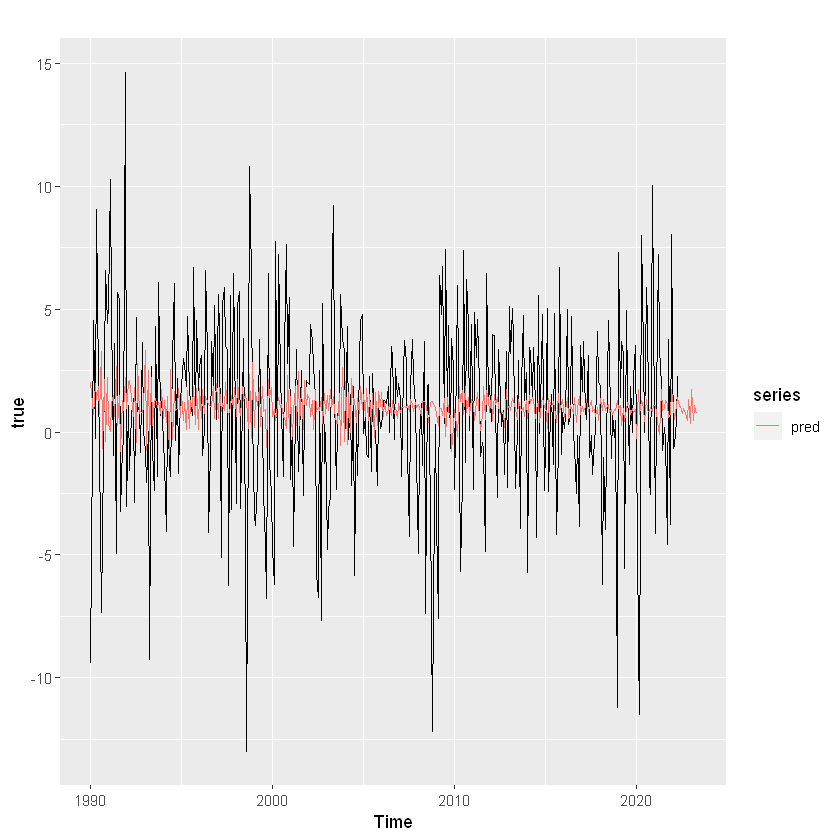

In [21]:
autoplot(true) + autolayer(pred)